# Introduction to Process mining

*With Process discovery we aim to find a suitable process model that can describe our business process and the sequence of events (traces) and activities that are performed within each trace. In addition to discovery of process model we can get statistics related such as frequency of events and time-to-execute, which help increase our understanding of the insufficiences are inherited in our process*

**For references and more information please visit PM4PY page, most of the code provided below comes from PM4PY official documentation** 

The data used in this tutorial are real logs obtaind from https://www.win.tue.nl/bpi/doku.php?id=2012:challenge&redirect=1id=2012/challenge
and as it is discribed in their website: it is an application process for a personal loan or overdraft within a global financing organization (Dutch Financial Institute)

## Load packages

In [1]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining 
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc 
from pm4py.objects.conversion.process_tree import converter as pt_converter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load logs

In [11]:
log = xes_importer.apply('financial_log.xes.gz')

In [20]:
log[1]   ## Printing the first trace

{'attributes': {'REG_DATE': datetime.datetime(2011, 10, 1, 8, 8, 58, 256000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))), 'concept:name': '173691', 'AMOUNT_REQ': '5000'}, 'events': [{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 8, 8, 58, 256000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}, '..', {'org:resource': '10809', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'W_Valideren aanvraag', 'time:timestamp': datetime.datetime(2011, 10, 10, 14, 17, 34, 633000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}]}

In [13]:
log[0][0]  ## printing the first event in first trace

{'org:resource': '112', 'lifecycle:transition': 'COMPLETE', 'concept:name': 'A_SUBMITTED', 'time:timestamp': datetime.datetime(2011, 10, 1, 0, 38, 44, 546000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))}

In [29]:
from pm4py.algo.filtering.log.start_activities import start_activities_filter
from pm4py.algo.filtering.log.end_activities import end_activities_filter

log_start = start_activities_filter.get_start_activities(log)
end_activities = end_activities_filter.get_end_activities(log)
log_start  # Printing the start activity in our log

{'A_SUBMITTED': 13087}

In [30]:
end_activities  # Printing the end activity in our log

{'W_Valideren aanvraag': 2747,
 'W_Wijzigen contractgegevens': 4,
 'A_DECLINED': 3429,
 'W_Completeren aanvraag': 1939,
 'A_CANCELLED': 655,
 'W_Nabellen incomplete dossiers': 452,
 'W_Afhandelen leads': 2234,
 'W_Nabellen offertes': 1290,
 'W_Beoordelen fraude': 57,
 'O_CANCELLED': 279,
 'A_REGISTERED': 1}

*Look like our process has one starting activity and multiple ends. All our 13087 cases started with "A_submitted" while the majority ended with either "A_declined" or "W_Valideren aanvraag"*

**Before applying one of the many process mining algorithms, it will be informatives if we get some statistics describing our log and process**
will start by understanding how many variants we have? how many cases in each variant?

*A process variant is a unique path from the very beginning to the very end of the process*

In [34]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics
variants = variants_filter.get_variants(log)
print(f"We have:{len(variants)} variants in our log")

We have:4366 variants in our log


In [41]:
## Let's try to understand how many cases do those variants have?

variants_count = case_statistics.get_variant_statistics(log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
variants_count[:10] ## Printing the top 10 variants by case number


[{'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,A_DECLINED', 'count': 3429},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,W_Afhandelen leads,W_Afhandelen leads,A_DECLINED,W_Afhandelen leads',
  'count': 1872},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,W_Afhandelen leads,W_Afhandelen leads,W_Afhandelen leads,W_Afhandelen leads,A_DECLINED,W_Afhandelen leads',
  'count': 271},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,W_Afhandelen leads,W_Afhandelen leads,A_PREACCEPTED,W_Completeren aanvraag,W_Afhandelen leads,W_Completeren aanvraag,A_DECLINED,W_Completeren aanvraag',
  'count': 209},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,W_Completeren aanvraag,W_Completeren aanvraag,A_DECLINED,W_Completeren aanvraag',
  'count': 160},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,W_Completeren aanvraag,W_Completeren aanvraag,A_CANCELLED,W_Completeren aanvraag',
  'count': 134},
 {'variant': 'A_SUBMITTED,A_PARTLYSUBMITTED,W_Afhandelen leads,W_Afhandelen leads,A_PREACCEPTED,W

In [47]:
print(f"This is very interesting! out of {len(log)} cases we have in our log, 3429 of them (i.e 26%) are in 1 variant.\nOnly 1 variant out of {len(variants)}. And when examining the variant, it is a 3 steps one which seems for unqualified loans")

This is very interesting! out of 13087 cases we have in our log, 3429 of them (i.e 26%) are in 1 variant.
Only 1 variant out of 4366. And when examining the variant, it is a 3 steps one which seems for unqualified loans


In [49]:
## Let's see what activities do we have in log? including their frequencies and considering all cases(no filter)

from pm4py.algo.filtering.log.attributes import attributes_filter
activities = attributes_filter.get_attribute_values(log, "concept:name")
activities

{'A_SUBMITTED': 13087,
 'A_PARTLYSUBMITTED': 13087,
 'A_PREACCEPTED': 7367,
 'W_Completeren aanvraag': 54850,
 'A_ACCEPTED': 5113,
 'O_SELECTED': 7030,
 'A_FINALIZED': 5015,
 'O_CREATED': 7030,
 'O_SENT': 7030,
 'W_Nabellen offertes': 52016,
 'O_SENT_BACK': 3454,
 'W_Valideren aanvraag': 20809,
 'A_REGISTERED': 2246,
 'A_APPROVED': 2246,
 'O_ACCEPTED': 2243,
 'A_ACTIVATED': 2246,
 'O_CANCELLED': 3655,
 'W_Wijzigen contractgegevens': 12,
 'A_DECLINED': 7635,
 'A_CANCELLED': 2807,
 'W_Afhandelen leads': 16566,
 'O_DECLINED': 802,
 'W_Nabellen incomplete dossiers': 25190,
 'W_Beoordelen fraude': 664}

**Few activities stands out "W_Completeren aanvraag", "W_Nabellen offertes" and "W_Nabellen incomplete dossiers" they have a lot of actions, it could be some sort of self-loop or rework or some other reason ofc, but clearly we should do something to prevent them from becoming bottelnecks**

### 1. Alpha minner:
The starting point for the Alpha algorithm are ordering relations (sorted by timestamp ofc) So, we do not consider the frequencies nor we consider other attributes!

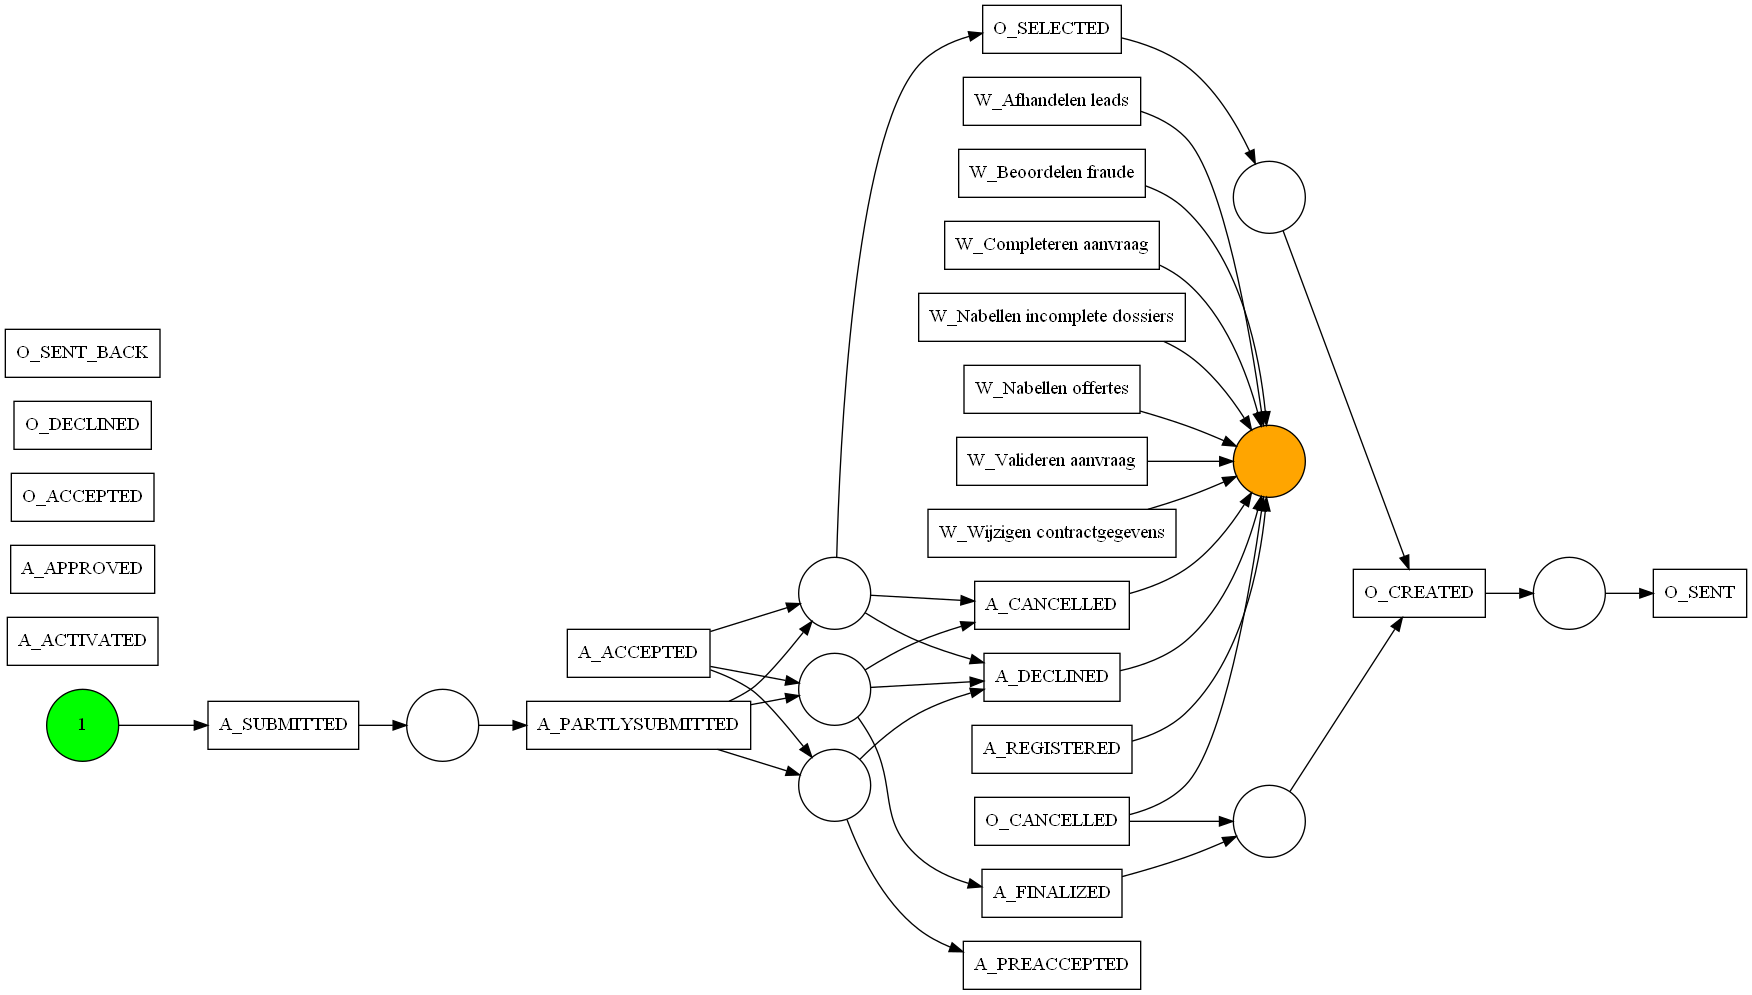

In [50]:
net, initial_marking, final_marking = alpha_miner.apply(log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

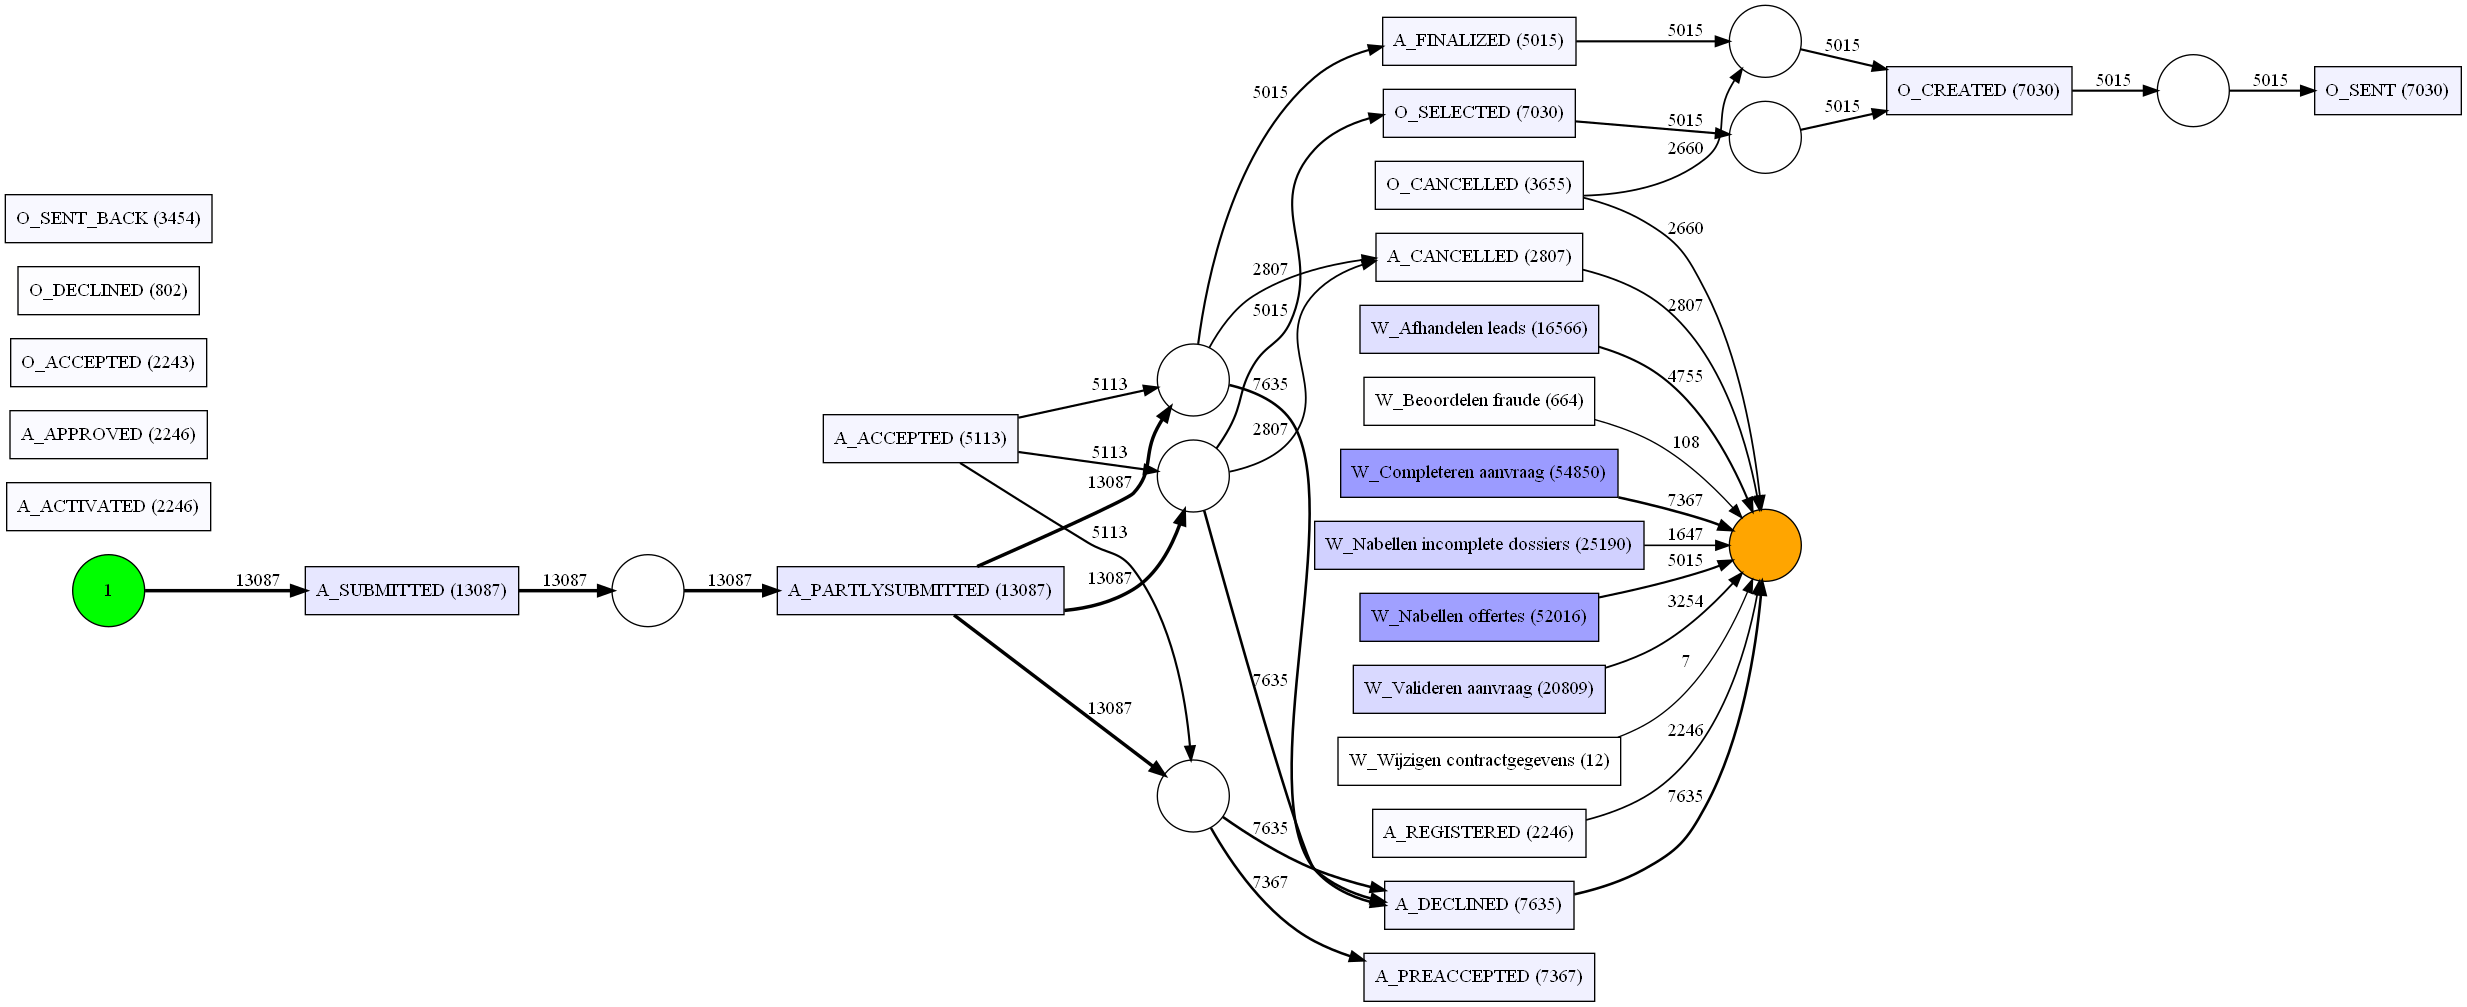

In [52]:
## Adding frequency

parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log)
pn_visualizer.view(gviz)

In [53]:
# it is difficult to see it here in notebook, so i would recommend to save it as picture - much clearer
pn_visualizer.save(gviz, "alpha_miner_petri_net.png")

## 2. Inductive minner

As per PM4Py documentation, The basic idea of Inductive Miner is about detecting a 'cut' in the log (e.g. sequential cut, parallel cut, concurrent cut and loop cut) and then recur on sublogs, which were found applying the cut, until a base case is found. The Directly-Follows variant avoids the recursion on the sublogs but uses the Directly Follows graph

 " * " is the loop, "->" is the sequence operator, "X" is the exclusive choice

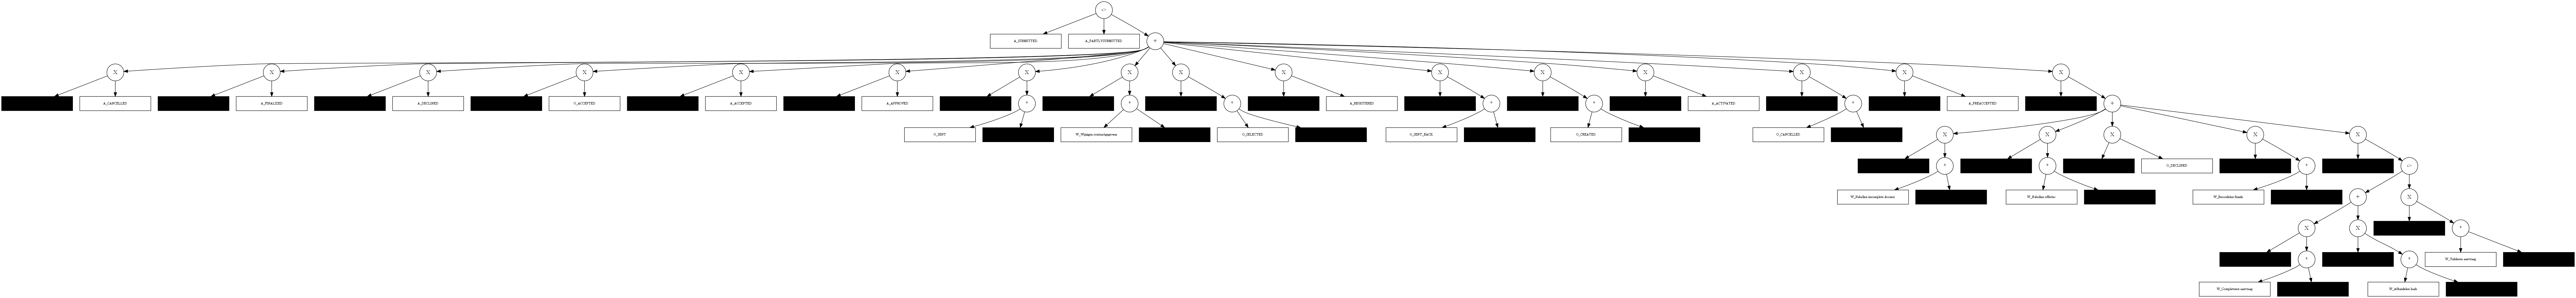

In [54]:
tree = inductive_miner.apply_tree(log)

gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

In [56]:
pn_visualizer.save(gviz,"Inductive_miner.png")

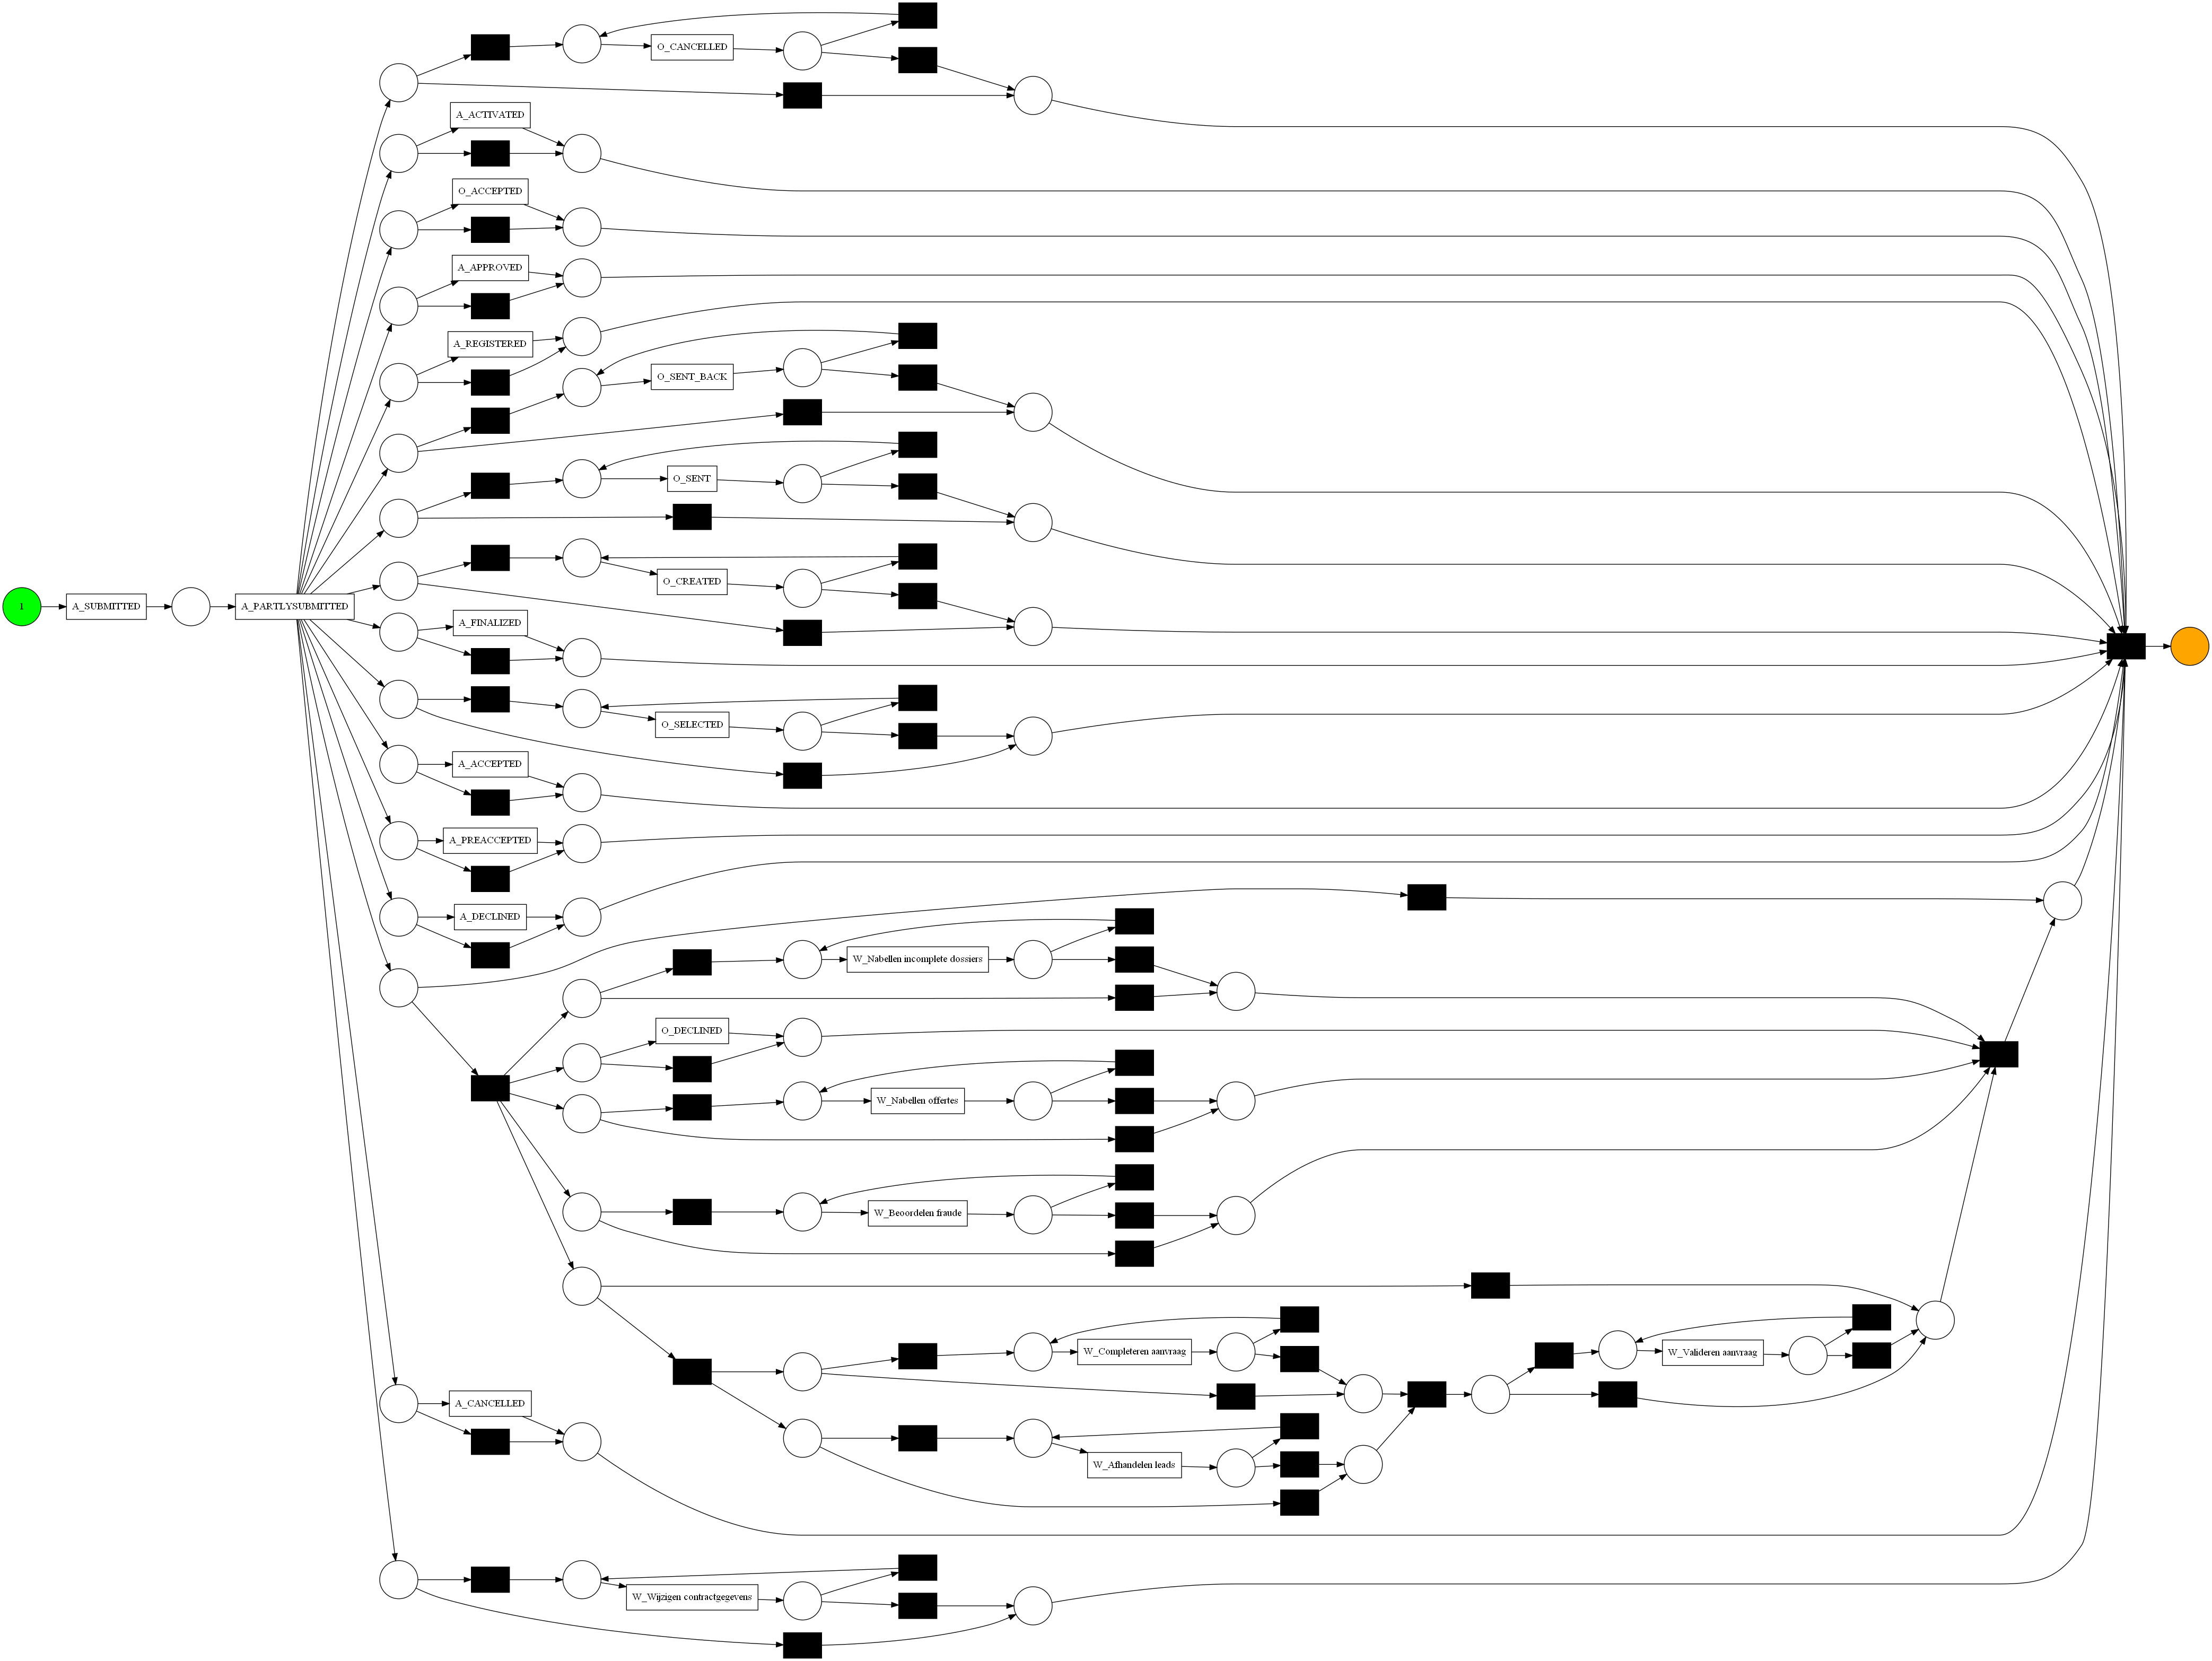

In [57]:
## In case you want to Convert the inductive miner into petri-net

net, initial_marking, final_marking = pt_converter.apply(tree, variant=pt_converter.Variants.TO_PETRI_NET)

gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)
pn_visualizer.save(gviz,"Inductive_miner_petri_net.png")

## 3. Heuristic Miner
Heuristics Miner is an algorithm that acts on the Directly-Follows Graph. The output of the Heuristics Miner is an Heuristics Net

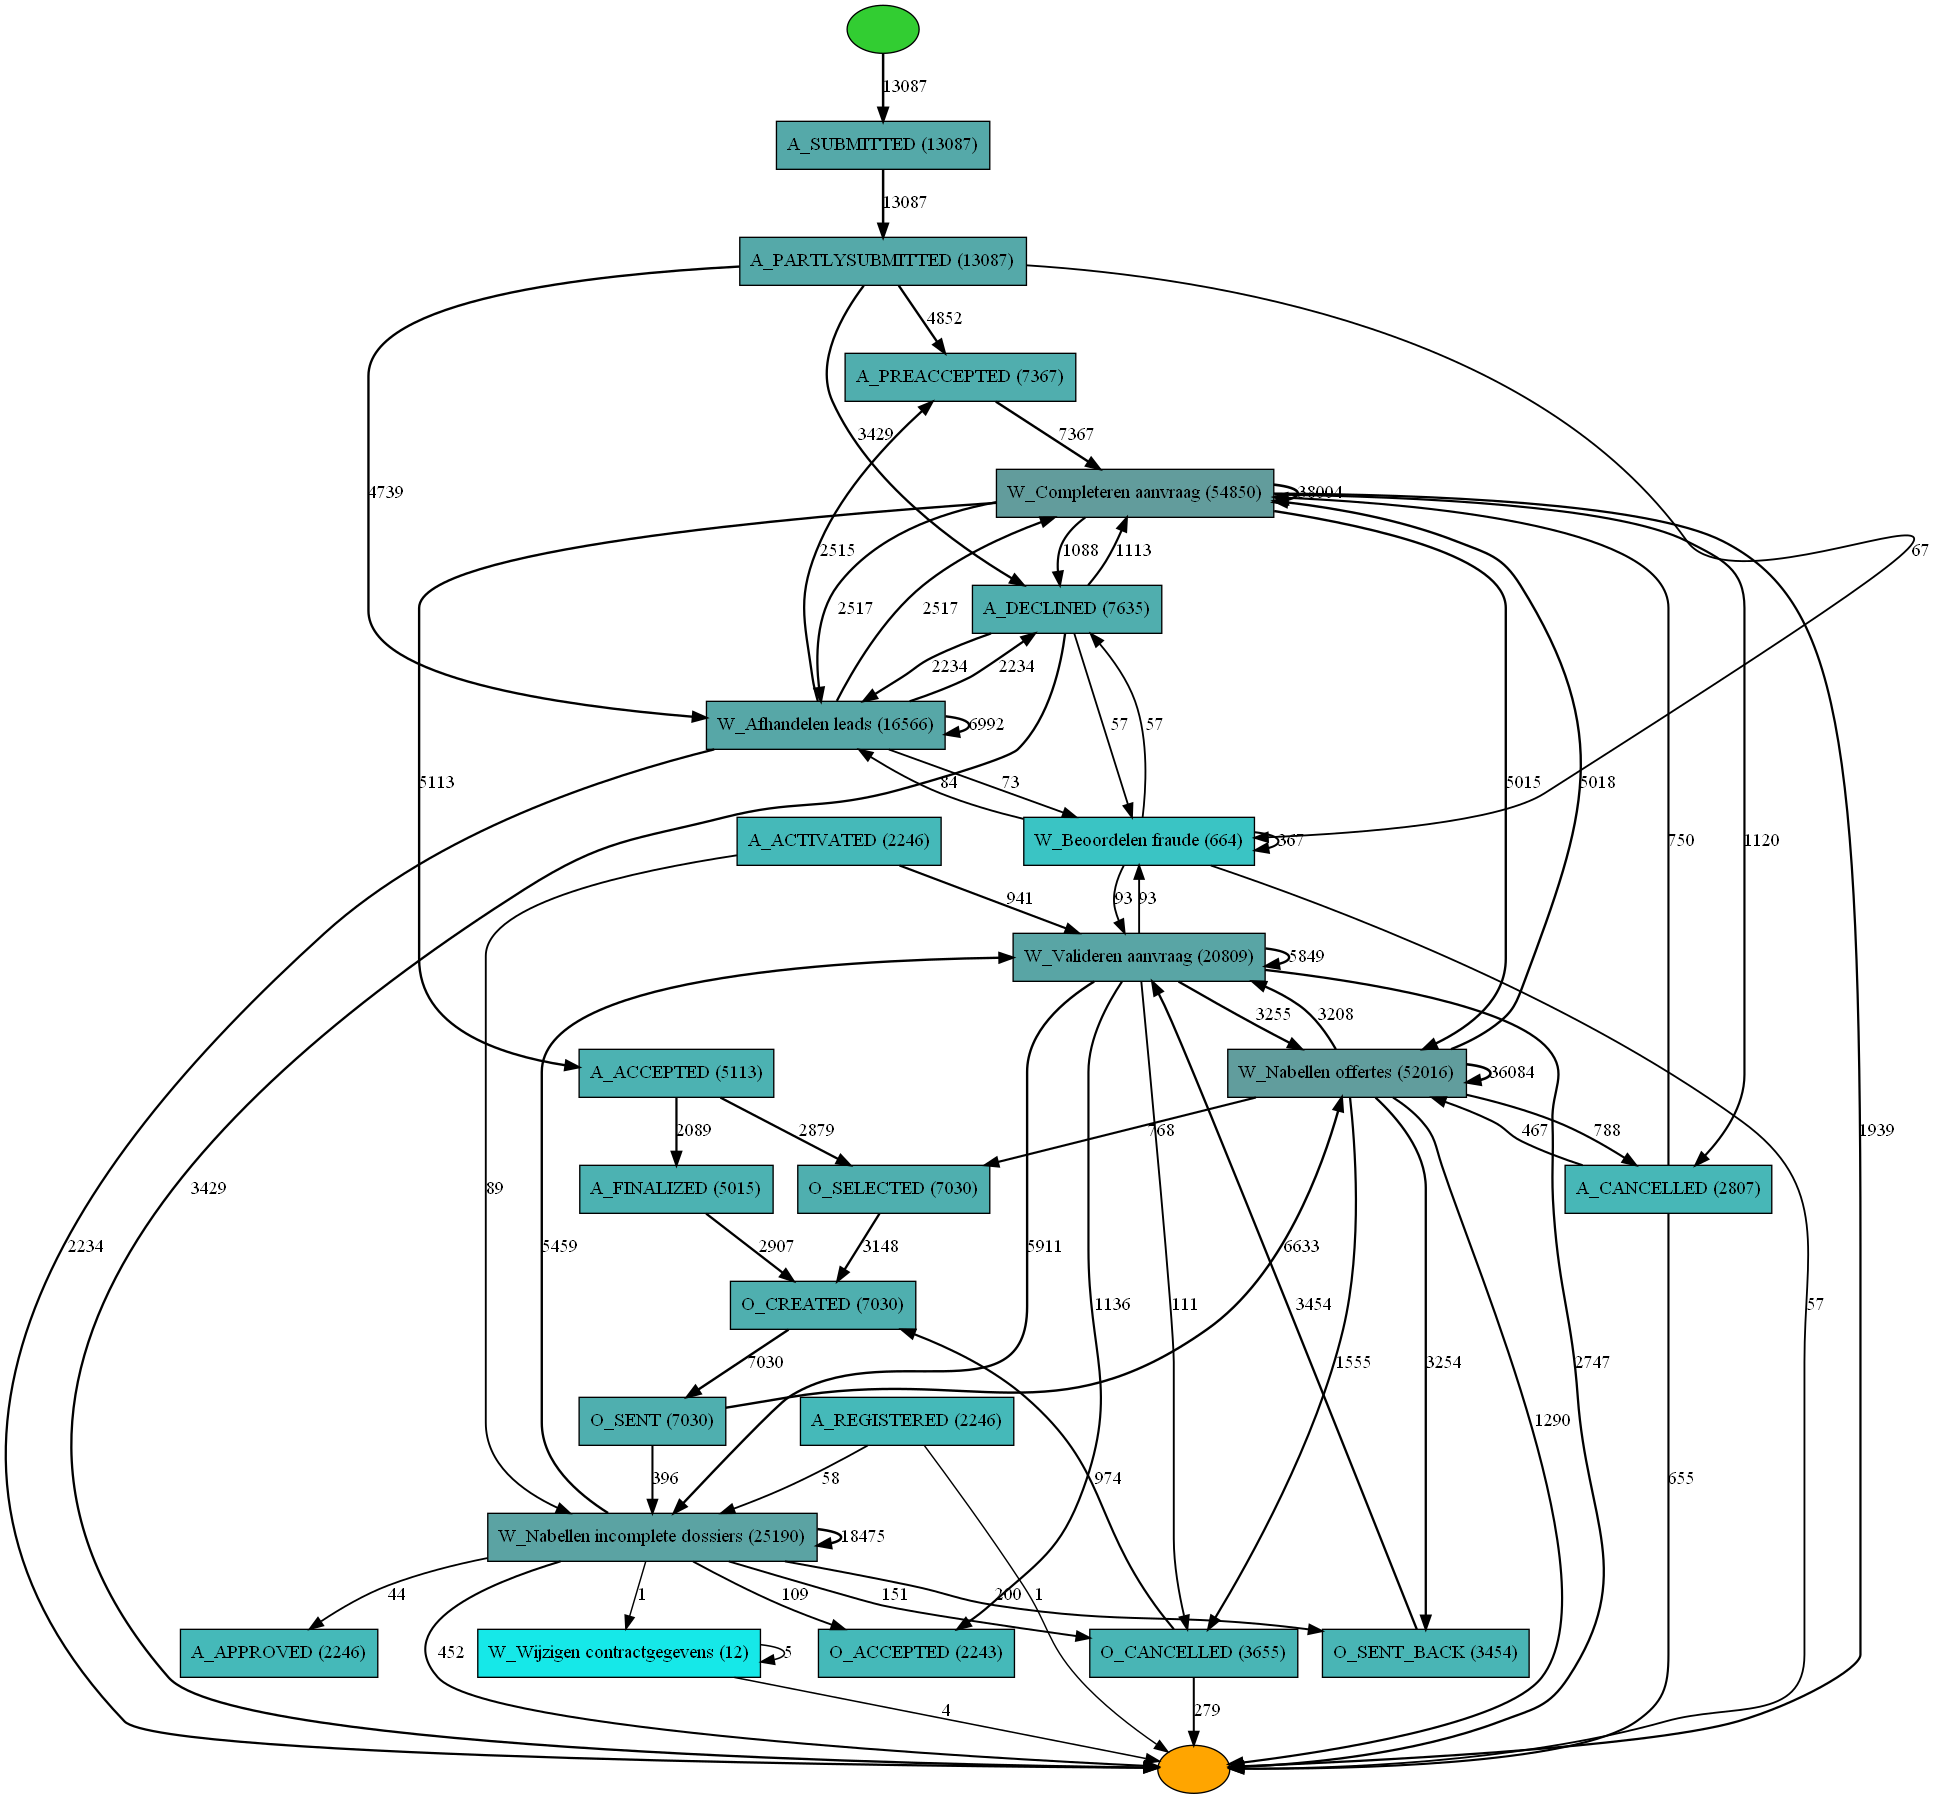

In [58]:
heu_net = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5})
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

In [59]:
## The Heurstic miner is very sensitive to dependency_threshold

hn_visualizer.save(gviz,"Heurstic_miner.png")

## 4. DFG - Direct flows graph with frequency and time between the edges

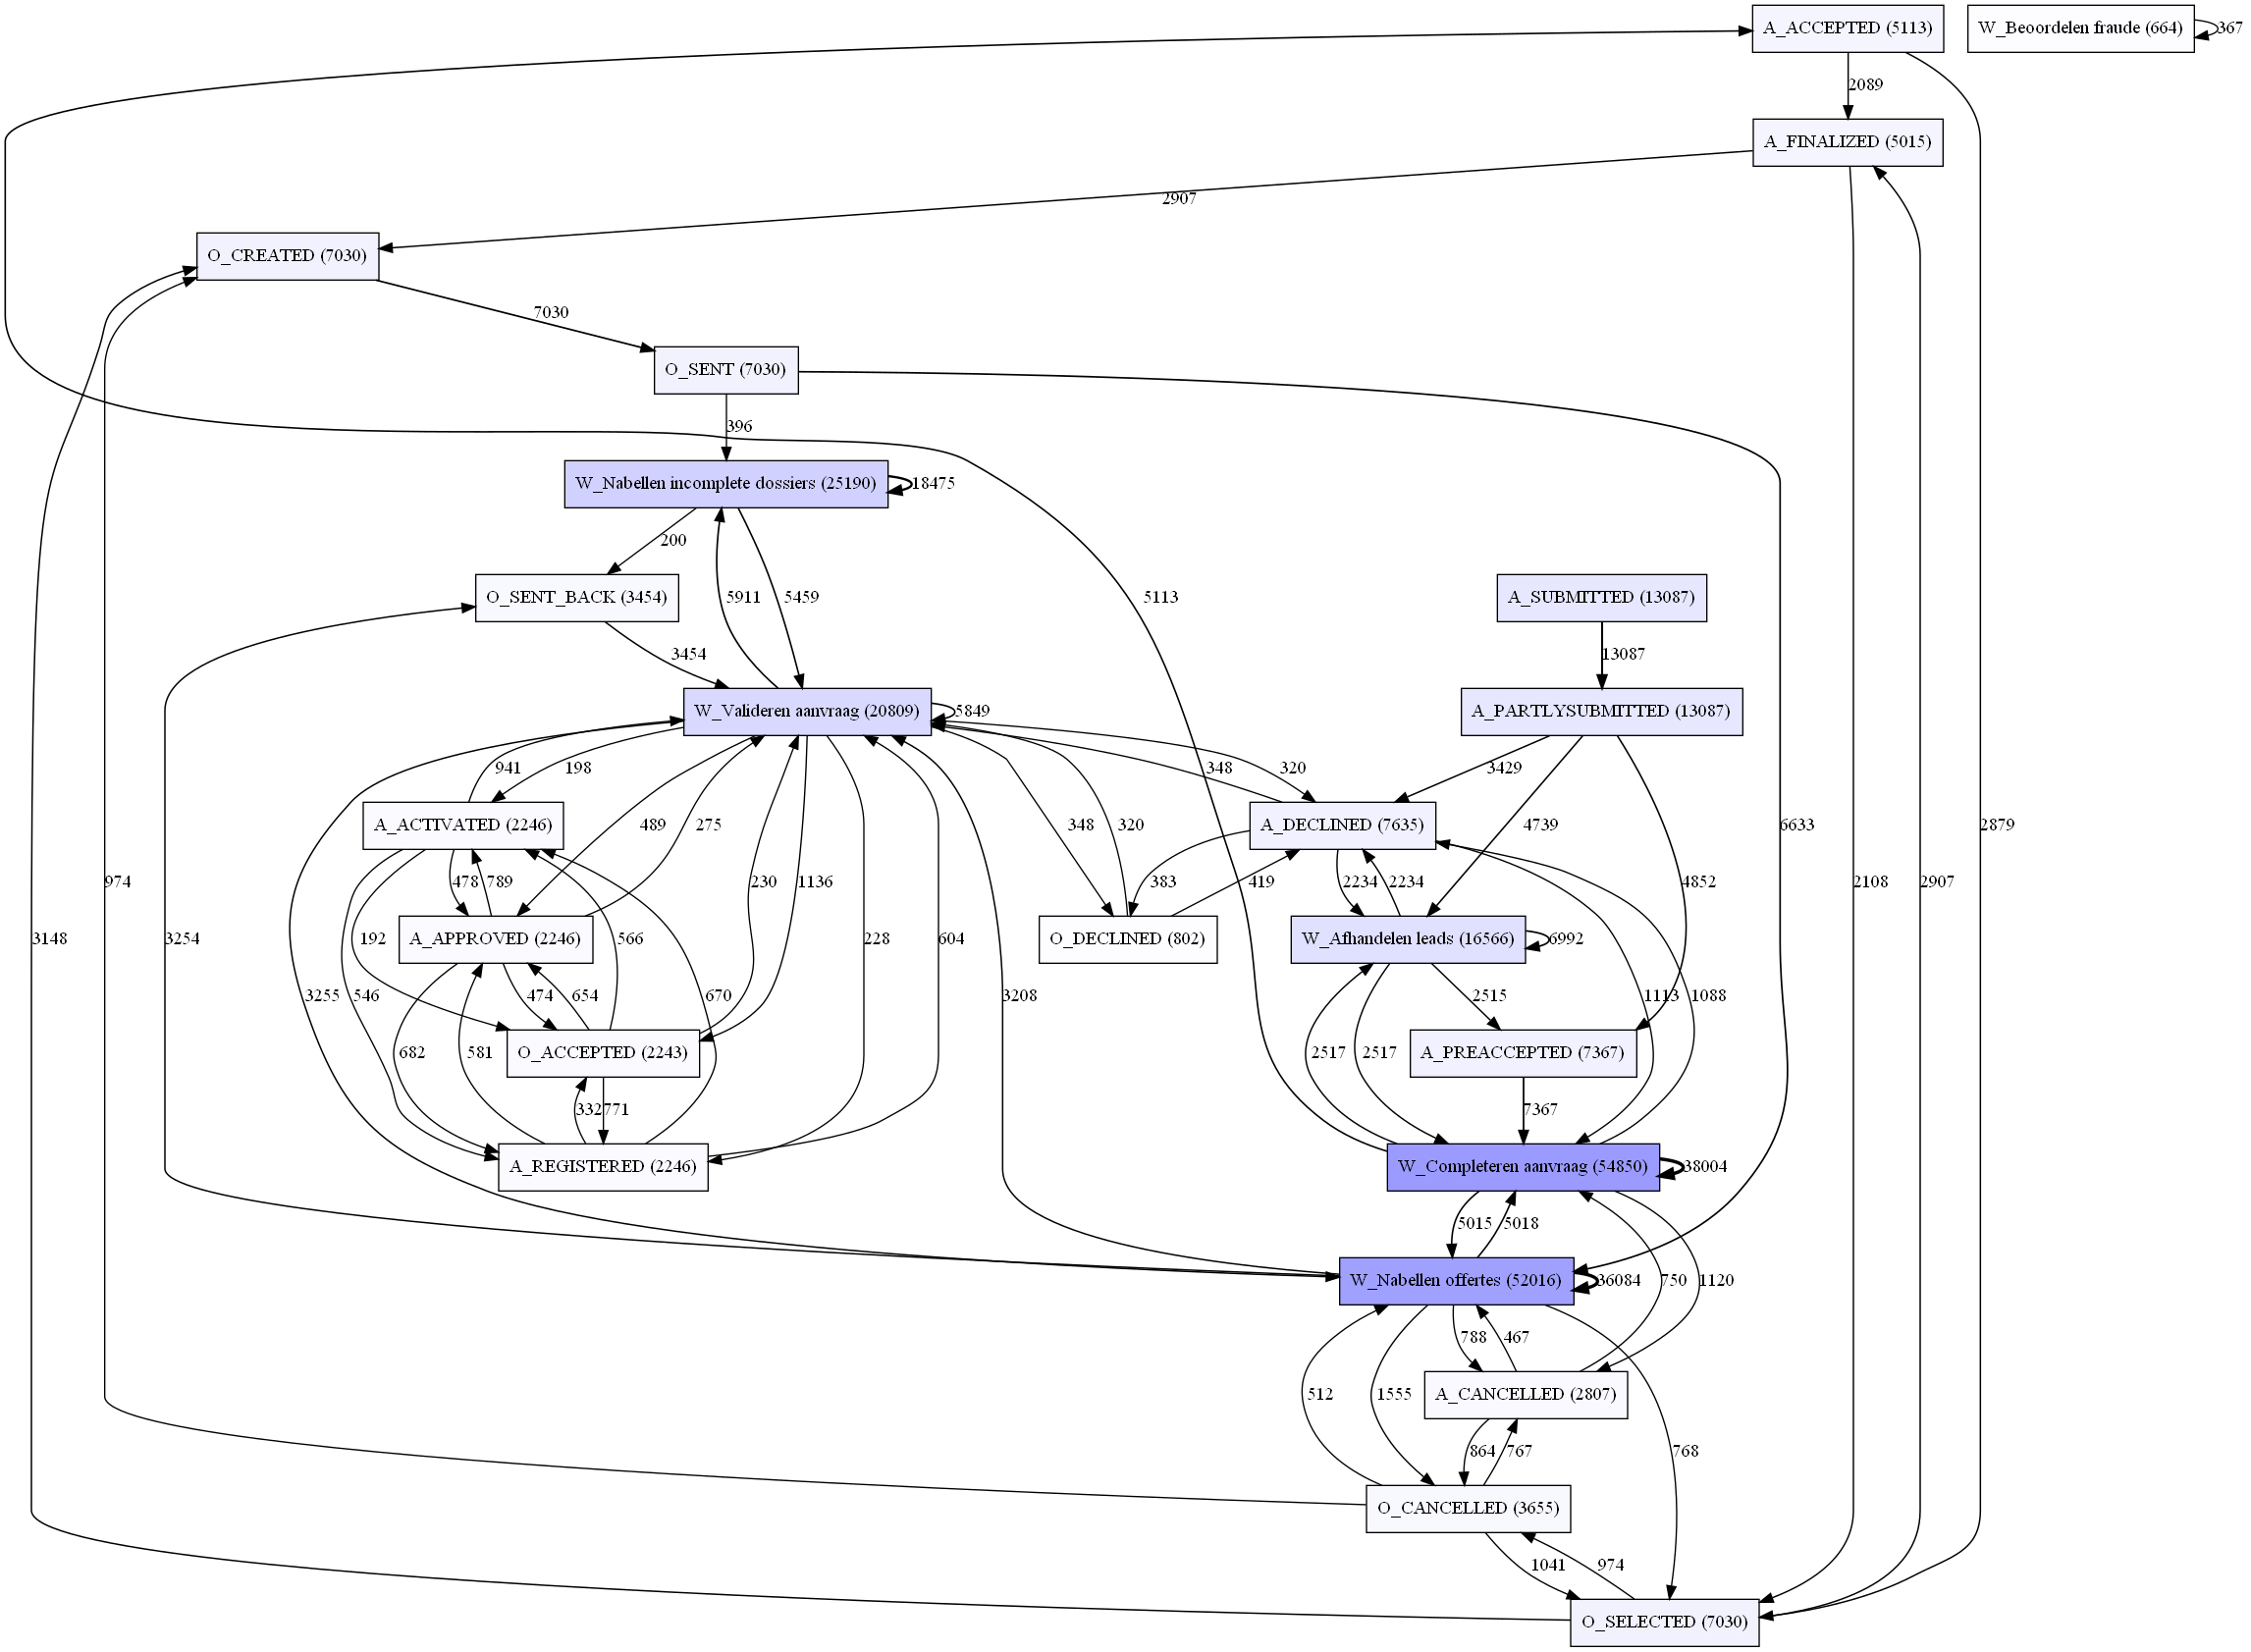

In [62]:
## First let's take the frequency:

dfg = dfg_discovery.apply(log)

from pm4py.visualization.dfg import visualizer as dfg_visualization
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)
dfg_visualization.save(gviz, "DFG_with_frequency.png")

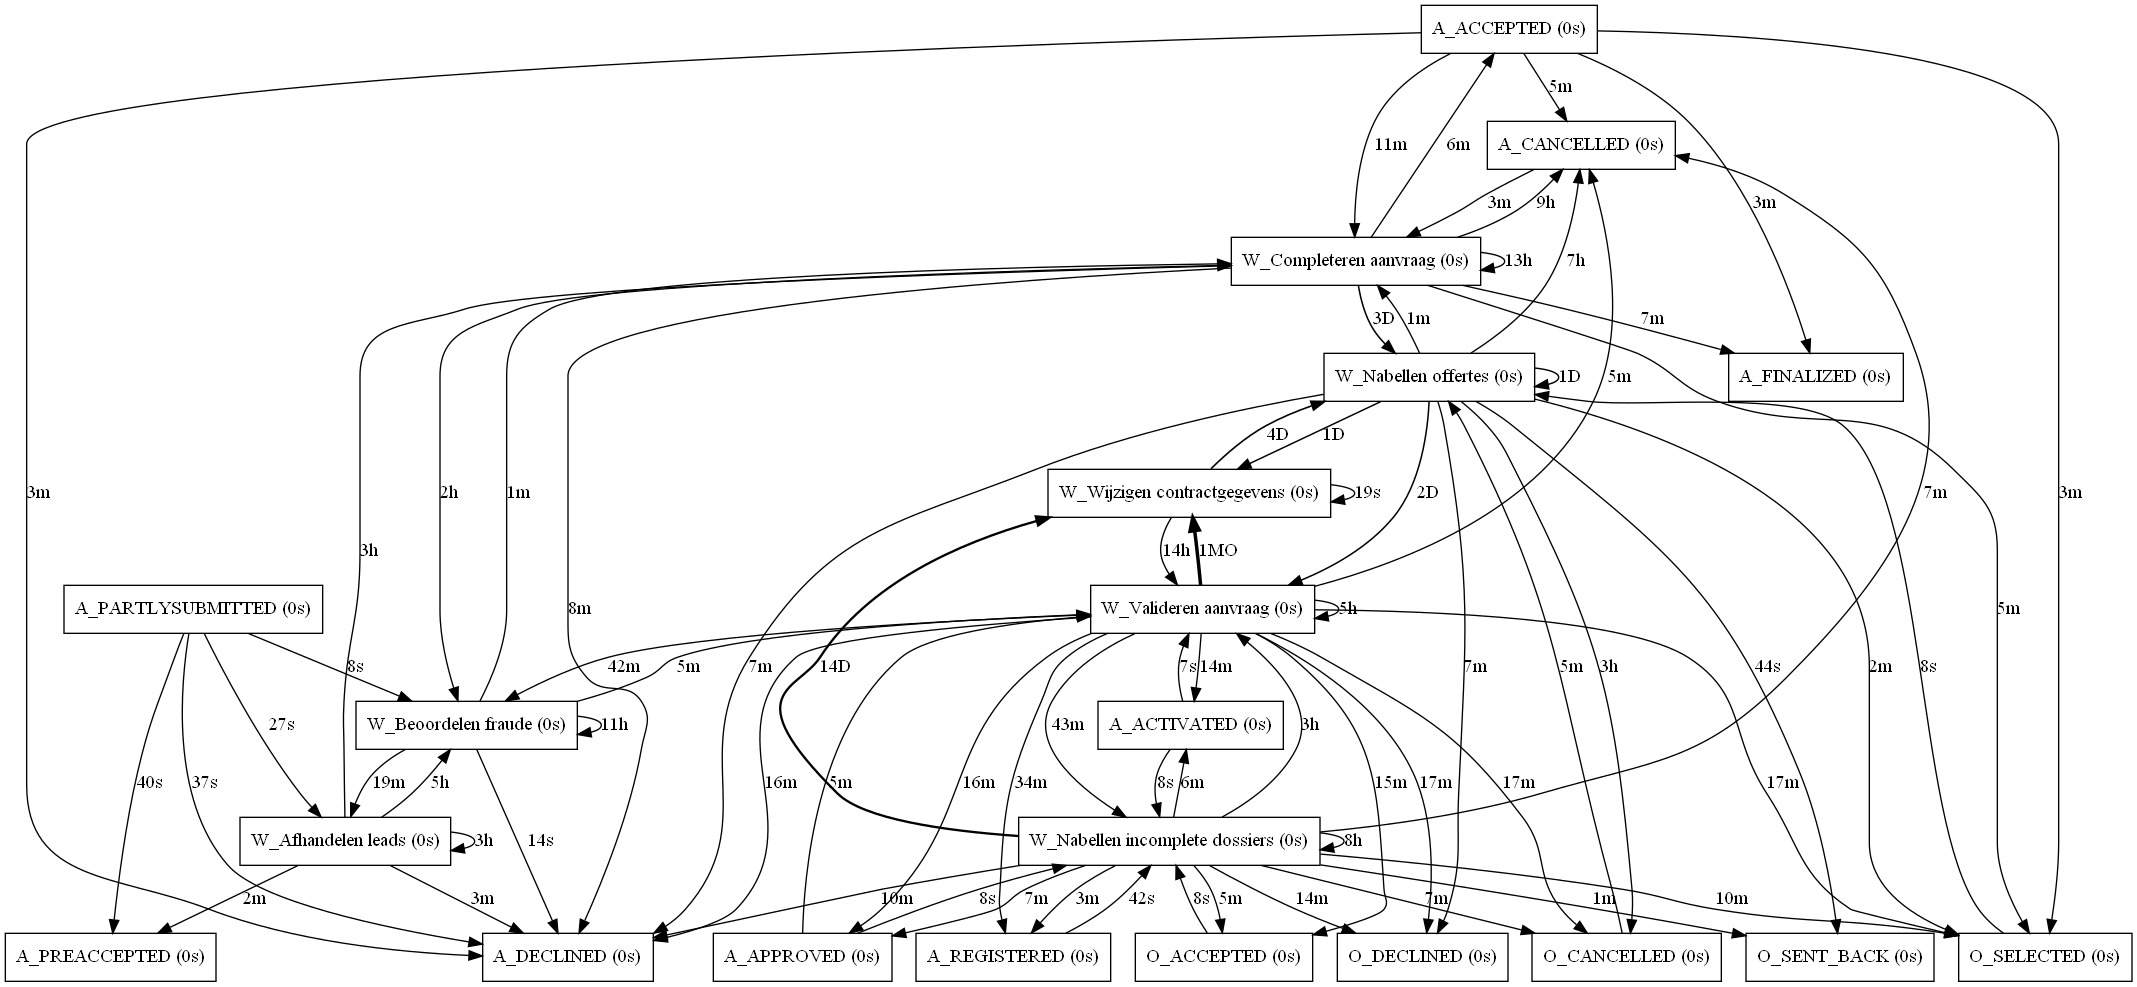

In [63]:
## Let's now take how much time it takes to travel between activities in our process

dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)
dfg_visualization.save(gviz, "DFG_with_time.png")

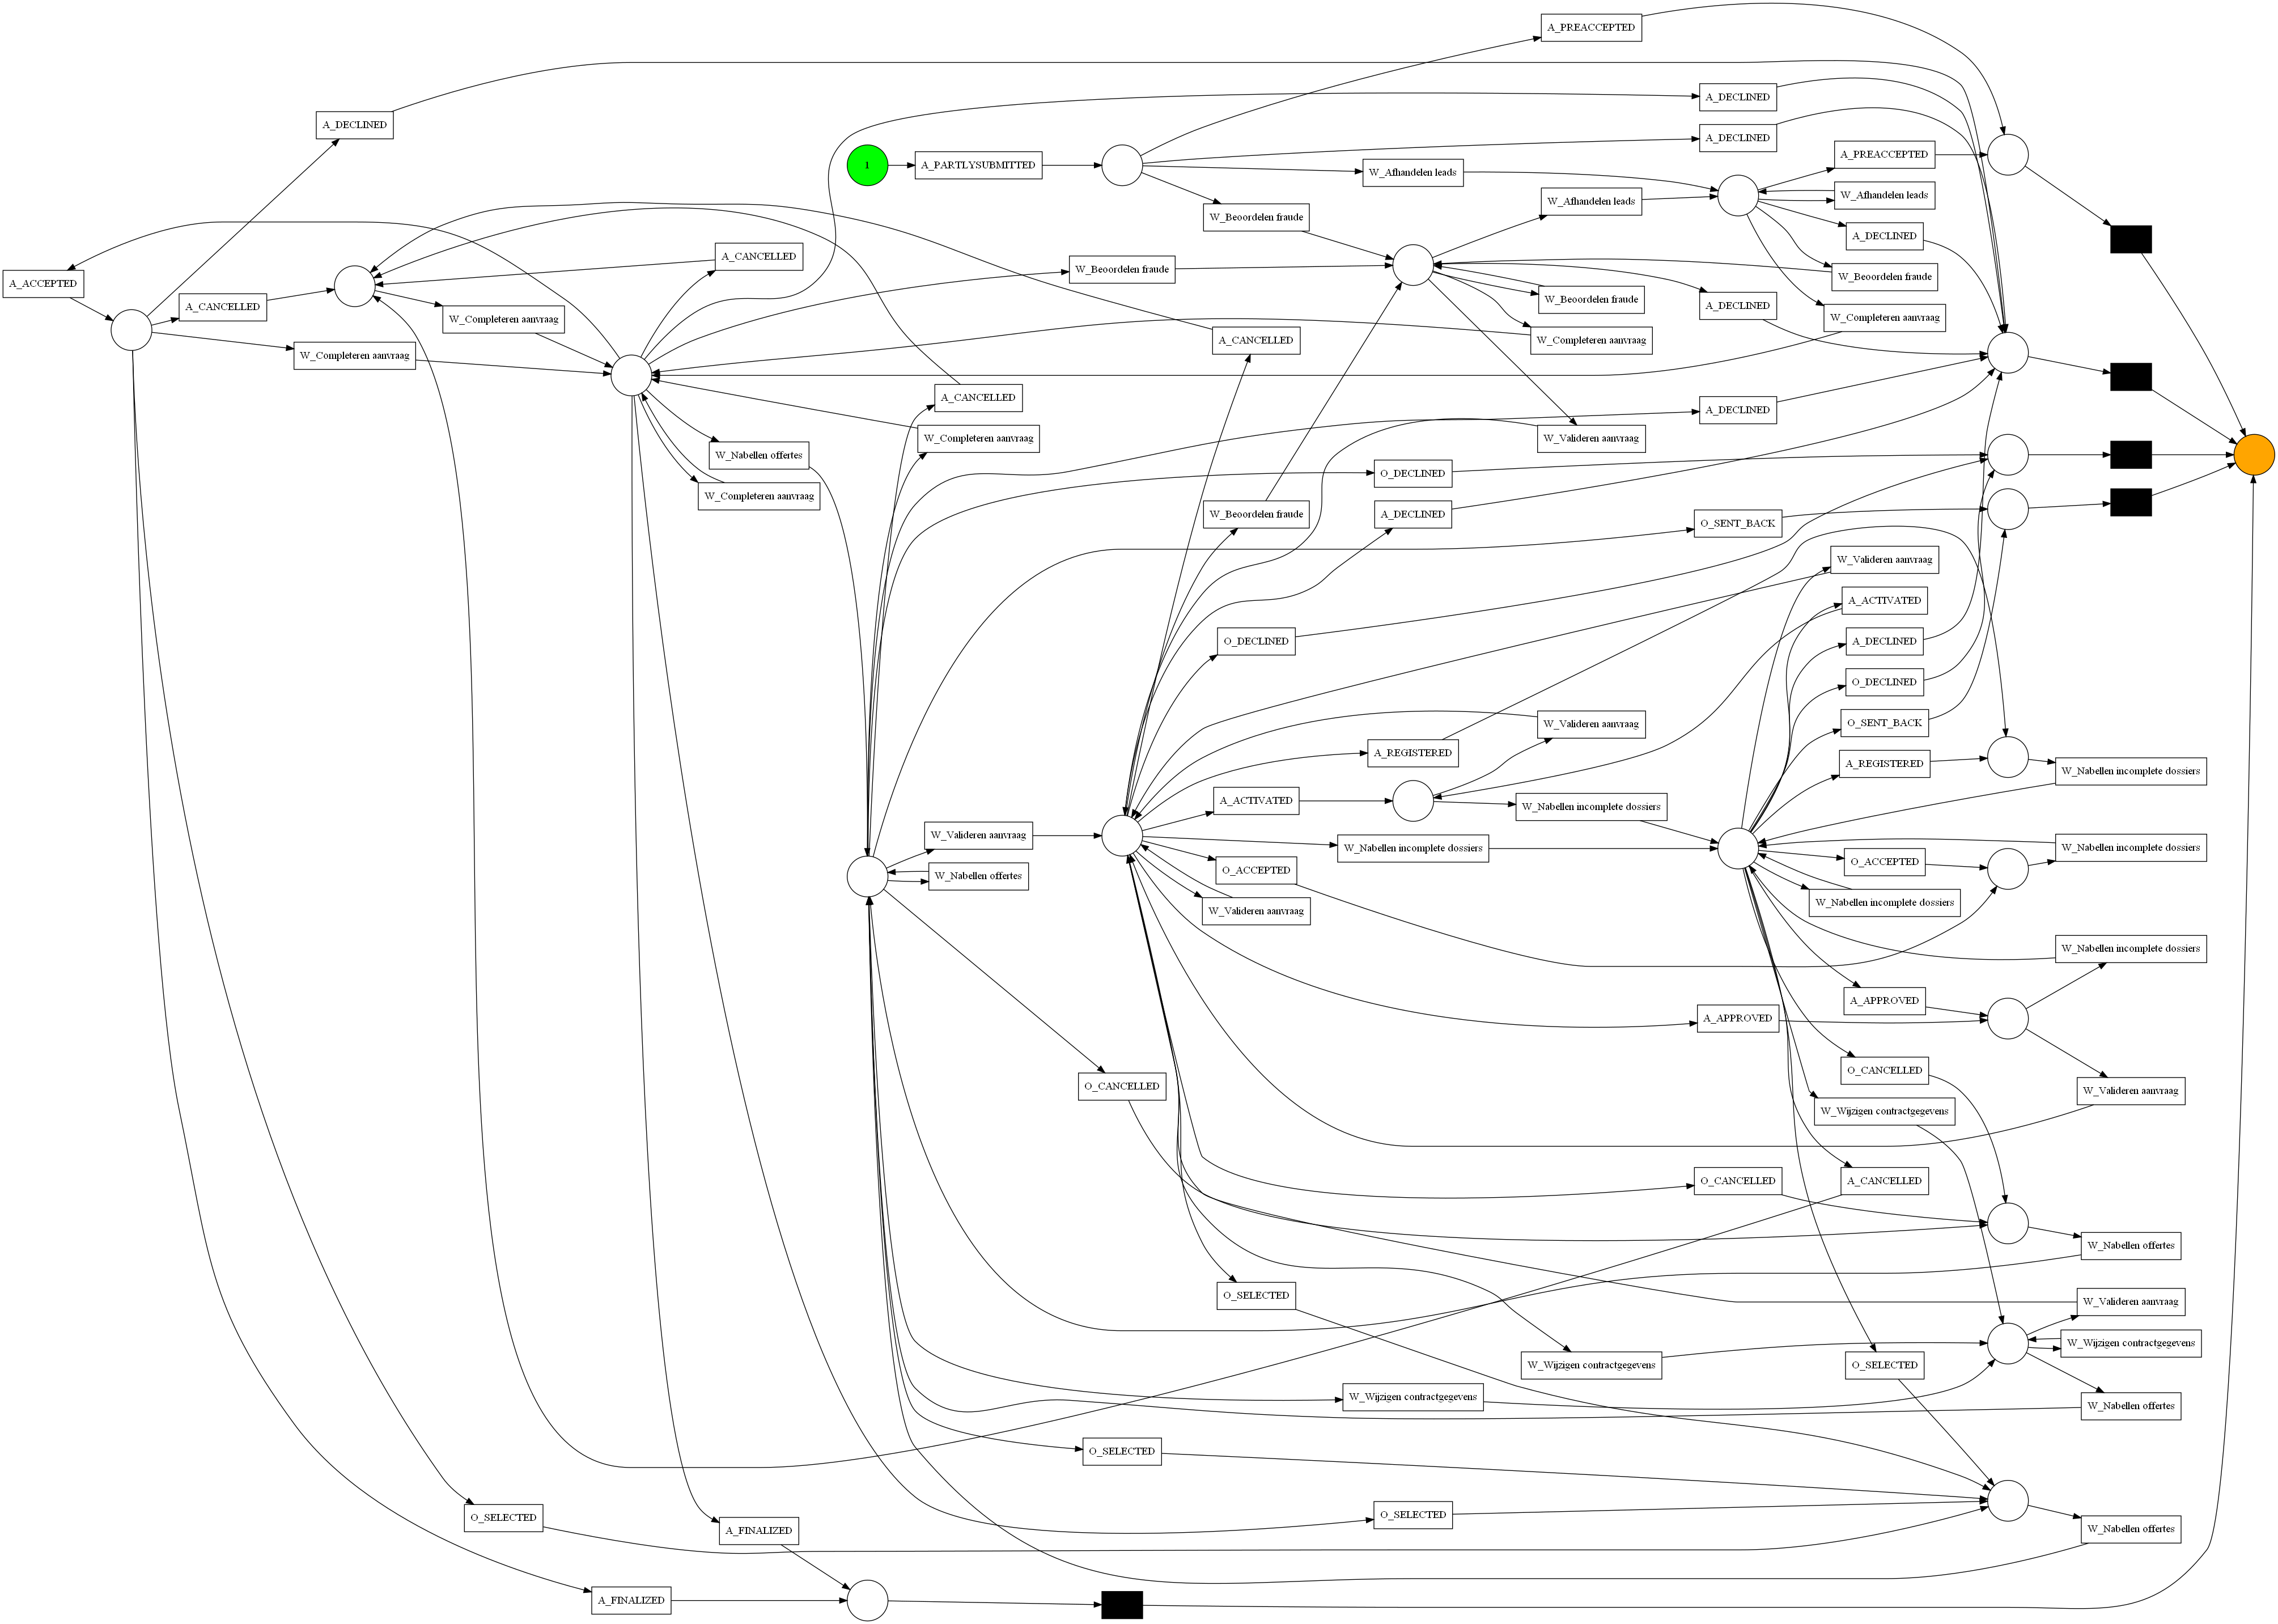

In [64]:
# Convert Directly-Follows Graph to a Workflow Net

from pm4py.objects.conversion.dfg import converter as dfg_mining
net, im, fm = dfg_mining.apply(dfg)
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

In another notebook I will be performing:
- Anomaly detections
- Decision Tree (root cause analysis)
- Other statistics such as: Dispersion ration, Cycle time and awaiting time, concurrent activities, replay fitness
- Monte carlo simulation
- Social network analysis